# CSC 3310 - Final Project Demo
Adam Haile, Aiden Miller, Leigh Goetsch  
11/20/2024

## Introduction
The Fast Fourier Transform (FFT) is an algorithm to compute the Discrete Fourier Transform (DFT) efficiently, reducing the computational complexity from $O(n^2)$ to $O(N\:log\:⁡N)$. It is used everywhere in modern computation from telecommunications, to video games, to cybersecurity.

## Part 1 - Implementing FFT

In [402]:
import numpy as np
import matplotlib.pyplot as plt

Let's first create a bit of sample data by generating a signal. This signal will have peaks of frequency at 1, 4, and 7. If our FFT algorithm is implemented correctly, we should see these same peaks when we convert the signal to the frequency domain.

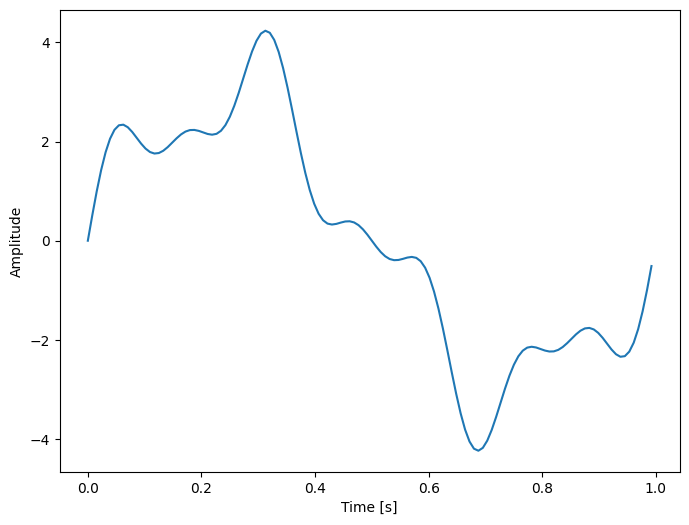

In [403]:
sr = 128
# sampling interval
ts = 1.0 / sr
t = np.arange(0, 1, ts)
 
freq = 1.
x = 3 * np.sin(2 * np.pi * freq * t)

freq = 4
x += np.sin(2 * np.pi * freq * t)

freq = 7   
x += 0.5 * np.sin(2 * np.pi * freq * t)

plt.figure(figsize = (8, 6))
plt.plot(t, x)
plt.ylabel('Amplitude')
plt.xlabel('Time [s]')

plt.show()

Now we will implement the Fast Fourier Transform. This implementation is the recursive Cooley-Tukey approach divides the input into even and odd indices, processes them recursively, and combines their results using complex exponential factors.

In [404]:
def fft(x):
    """
    A recursive implementation of the Cooley-Tukey FFT algorithm,
    the input should have a length of the power of 2.
    """
    N = len(x)
    
    # Conquer each subproblem if the length of the input array is greater than 1
    if N == 1:
        return x
    else:
        # Divide the input array into even and odd elements
        X_even = fft(x[::2])
        X_odd = fft(x[1::2])

        # Combine the results of the two halfs
        factor = np.exp(-2j * np.pi * np.arange(N) / N)
        half_N = N // 2
        return np.concatenate([
            X_even + factor[:half_N] * X_odd,
            X_even + factor[half_N:] * X_odd
        ])

Let's compare!

We can compare our implementation to the numpy version of the FFT algorithm. For both, we should see the same peaks, and we should see a very marginal difference between the max values of each frequency. There will be small amounts of difference since the algorithm deals with highly precise complex numbers, which means there will be some amount of floating point error.

For the purposes of demonstration, if it passes np.allclose(), the difference is marginal enough.

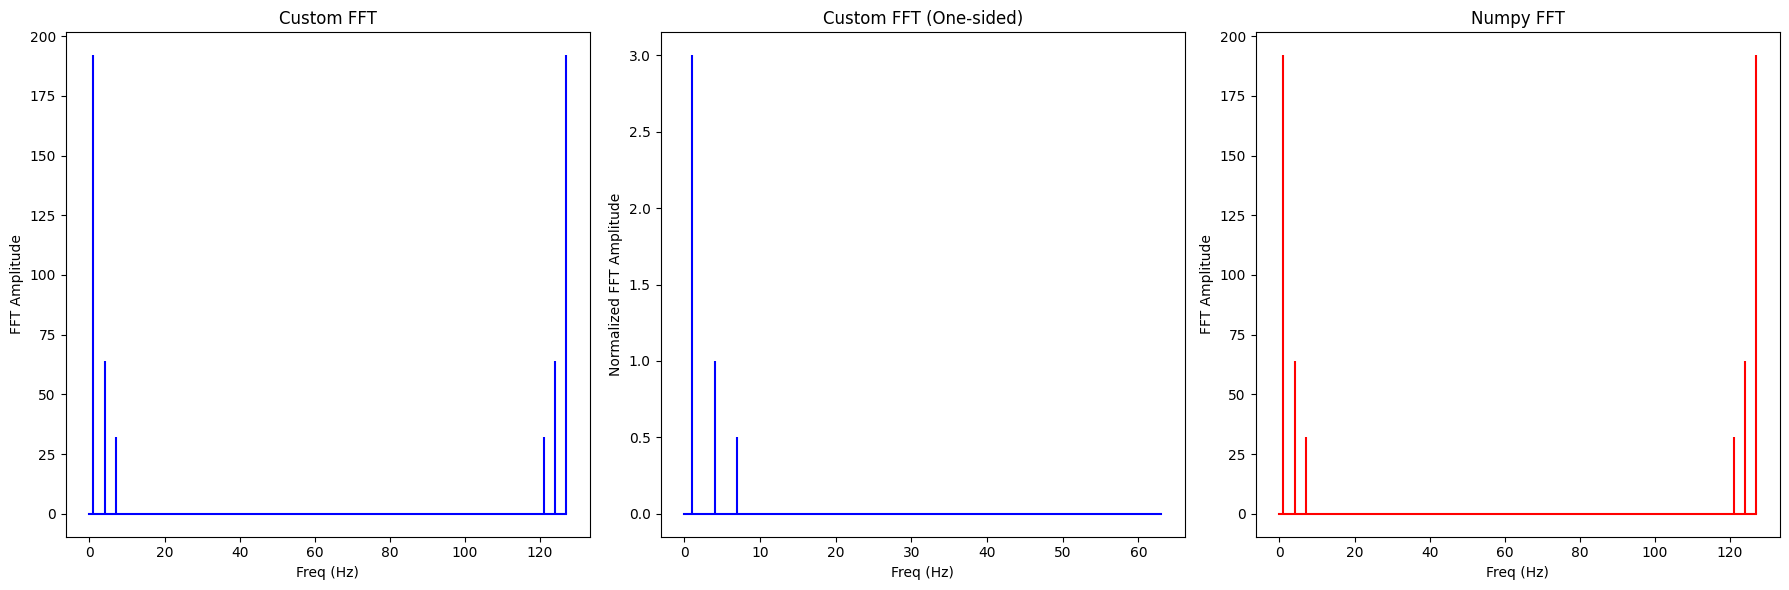

Difference between custom FFT and numpy FFT:
1.4840566052341196e-13
Is the difference marginal? Yes
Indices with frequency peaks in Normalized FFT: [1 4 7]


In [405]:
from scipy.signal import find_peaks

X_custom = fft(x)

X_numpy = np.fft.fft(x)

N = len(X_custom)
n = np.arange(N)
T = N/sr
freq = n/T

plt.figure(figsize = (18, 6))

plt.subplot(1, 3, 1)
plt.stem(freq, abs(X_custom), 'b', markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude')
plt.title('Custom FFT')

n_oneside = N//2
f_oneside = freq[:n_oneside]
X_custom_oneside = X_custom[:n_oneside]/n_oneside

plt.subplot(1, 3, 2)
plt.stem(f_oneside, abs(X_custom_oneside), 'b', markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('Normalized FFT Amplitude')
plt.title('Custom FFT (One-sided)')

plt.subplot(1, 3, 3)
plt.stem(freq, abs(X_numpy), 'r', markerfmt=" ", basefmt="-r")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude')
plt.title('Numpy FFT')

plt.tight_layout()
plt.show()

difference = np.abs(X_custom - X_numpy)
print("Difference between custom FFT and numpy FFT:")
print(np.max(difference))
print("Is the difference marginal?", "Yes" if np.allclose(X_custom, X_numpy) else "No")

peaks, _ = find_peaks(abs(X_custom_oneside), height=0.0001)
print("Indices with frequency peaks in Normalized FFT:", peaks)

Let's also run a couple of tests to ensure our one example isn't a fluke

In [406]:
# Test 1: Basic single-element array
x = [1]
expected = np.fft.fft(x)
assert np.allclose(fft(x), expected), "Test 1 Failed: Single element array"

# Test 2: Power-of-2 length input (basic case)
x = [1, 0, 0, 0]
expected = np.fft.fft(x)
assert np.allclose(fft(x), expected), "Test 2 Failed: Power-of-2 input length"

# Test 3: Power-of-2 length input (arbitrary values)
x = [1, 2, 3, 4]
expected = np.fft.fft(x)
assert np.allclose(fft(x), expected), "Test 3 Failed: Arbitrary power-of-2 input"

# Test 4: Complex input
x = [1+1j, 2+2j, 3+3j, 4+4j]
expected = np.fft.fft(x)
assert np.allclose(fft(x), expected), "Test 4 Failed: Complex numbers"

# Test 5: Real numbers with symmetry
x = [1, 2, 2, 1]
expected = np.fft.fft(x)
assert np.allclose(fft(x), expected), "Test 5 Failed: Symmetric real input"

# Test 6: All zeros
x = [0, 0, 0, 0]
expected = np.fft.fft(x)
assert np.allclose(fft(x), expected), "Test 6 Failed: All zeros"

# Test 7: Impulse signal
x = [1, 0, 0, 0, 0, 0, 0, 0]
expected = np.fft.fft(x)
assert np.allclose(fft(x), expected), "Test 7 Failed: Impulse signal"

# Test 8: Large power-of-2 array
x = np.random.rand(1024)
expected = np.fft.fft(x)
assert np.allclose(fft(x), expected), "Test 8 Failed: Large input array"

# Test 9: Non-power-of-2 input (should raise an exception or handle)
try:
    x = [1, 2, 3]
    fft(x)
    raise AssertionError("Test 9 Failed: Non-power-of-2 input should fail")
except ValueError:
    pass
except Exception as e:
    pass

x = [7]
expected = np.fft.fft(x)
assert np.allclose(fft(x), expected), "Test 10 Failed: Input length 1"

print("All tests passed!")

All tests passed!


## Part 2 - Using FFT
Now, let's make use of our FFT algorithm. One use of FFT is in cybersecurity and encryption techniques. The implementation written will transform both the data and encryption key into the frequency domain. Encryption is then performed using element-wise multiplication, and decryption divdes the encrypted data by the transformed key, and uses Inverse FFT to recover the data.

In [407]:
def fft_encrypt(data, key):
    """
    Encrypt data using the FFT algorithm.
    
    Args:
        data (list of floats): The input data to encrypt, should have a length of a power of 2.
        key (list of floats): The encryption key, same length as the data.
        
    Returns:
        list of complex: The encrypted data.
    """
    if len(data) != len(key) or (len(data) & (len(data) - 1)) != 0:
        raise ValueError("Data and key must have the same length and the length must be a power of 2.")

    fft_data = fft(data)
    fft_key = fft(key)

    encrypted_fft = fft_data * fft_key

    return encrypted_fft


def fft_decrypt(encrypted_fft, key):
    """
    Decrypt data encrypted using the FFT algorithm.
    
    Args:
        encrypted_fft (list of complex): The encrypted data in the frequency domain.
        key (list of floats): The encryption key used for encryption.
        
    Returns:
        list of floats: The decrypted data.
    """
    if len(encrypted_fft) != len(key) or (len(encrypted_fft) & (len(encrypted_fft) - 1)) != 0:
        raise ValueError("Encrypted data and key must have the same length and the length must be a power of 2.")
    
    fft_key = fft(key)
    
    decrypted_fft = encrypted_fft / fft_key
    
    decrypted_data = np.fft.ifft(decrypted_fft).real
    
    return decrypted_data

To process ASCII messages using our encyption/decryption methods, we need to do some processing on our data. The first thing we need to do is convert the characters to their numerical representations. We also need to pad this numerical data to a length of a power of 2. This is required for FFT to process the signal correctly. We also will want a method to convert the numerical representations back to the original string.

*Why do we need to pad the data?*: The Cooley-Tukey algorith recursively splits the input data into two halves, with one containing the even-indexed elements nad the other the odd-indexed elements. Due to this approach, the algorithm works when the number of elements can be divided down to 1, which happens only if the number of elements $N$ is a power of 2 $(N = 2^k)$. This is also due to values computed in FFT which are called "twiddle factors". These factors depend on the size $N$ of the input. When $N$ is not a power of 2, the twiddle factor computations of subproblems become more irregulare and break down. These would require a different and less efficient implementation.

*How is the padding non-destructive?*: The padding technique used is zero-padding. Zero padding means that we extend the original message with zeros to increase its length to the nearest power of 2. This is non-destructive because zeros do not introduce any new frequency components to the data in the frequency domain. In the time domain, this is like adding "nothing" to the end of a message, which will leave the original data intact.

In [408]:
def message_to_numerical(message):
    """
    Convert a string message to a list of ASCII values.
    """
    return [ord(char) for char in message]

def numerical_to_message(numbers):
    """
    Convert a list of numerical ASCII values back to a string.
    """
    return ''.join(chr(int(round(num))) for num in numbers)

def pad_to_power_of_two(data):
    """
    Pad a list with zeros to make its length a power of 2.
    """
    n = len(data)
    next_power_of_two = 2**int(np.ceil(np.log2(n)))
    return np.pad(data, (0, next_power_of_two - n), constant_values=0)

Once we have this, we can run it! The steps for this are as follows:
1. Write our message to encrypt.
2. Convert it to a numerical representation.
3. Pad our message.
4. Create a key which is of equal length of our message. This key can be a random set of numbers.
5. We can encrypt our padded message using the FFT encryption method, and our key.

We can then perform these steps backwards to decrypt our message and get the original text back!

In [409]:
message = "Hello, World! This message has been encrypted using FFT!"

numerical_message = message_to_numerical(message)

padded_message = pad_to_power_of_two(numerical_message)

key = np.random.rand(len(padded_message))

encrypted_message = fft_encrypt(padded_message, key)

print("Original Message:", message)
# print("Numerical Message:", numerical_message)
# print("Padded Numerical Message:", padded_message)
print("Key:", key)
# print("Encrypted Message:", encrypted_message)

decrypted_numerical = fft_decrypt(encrypted_message, key)

decrypted_message = numerical_to_message(decrypted_numerical[:len(numerical_message)])

# print("Decrypted Numerical Message:", decrypted_numerical)
print("Decrypted Message:", decrypted_message)

Original Message: Hello, World! This message has been encrypted using FFT!
Key: [7.78276167e-01 8.48345270e-01 4.90419908e-01 1.85348587e-01
 9.95815293e-01 1.29355761e-01 4.71457319e-01 6.80930992e-02
 9.43850857e-01 9.64924941e-01 7.19389062e-01 3.49992844e-01
 2.54382401e-01 2.65303325e-01 1.27294025e-01 5.25808953e-01
 1.41817276e-01 3.16730667e-01 6.26706476e-01 7.27543610e-01
 2.42727046e-02 4.30115984e-01 6.52124595e-01 8.53245976e-01
 4.75324782e-01 9.69205872e-01 2.65632548e-01 1.35087066e-02
 4.83752865e-01 2.56113795e-01 8.23717672e-01 2.32772672e-01
 3.10629218e-01 7.91227431e-01 7.15143252e-01 5.58051237e-01
 7.04948062e-01 4.18636864e-01 5.31004761e-03 1.13551285e-02
 5.11221788e-01 8.32909797e-02 5.10754802e-02 9.65516639e-01
 8.59002640e-01 1.52027227e-01 6.64218590e-04 9.41667795e-01
 2.78325298e-01 1.85897603e-01 6.91508108e-01 1.08903739e-01
 2.64649598e-01 9.75094680e-01 6.39462774e-01 5.20677791e-01
 3.97918615e-01 7.74500955e-01 1.40957477e-01 9.67337802e-01
 8.61

### Advantages and Disadvantages
Advantages:
 - FFT is an efficient algorithm. This makes it suitable for large datasets which need immediate encryption.
 - It is an unconvential method of encryting data, so attackers may not be able to understand how to decrypt the data.

Disadvantages:
 - Since FFT operates in the frequency domain, certain patterns might be apparent in the encrypted data which can allow for an attacker to determine predictable relationships.
 - Since the technique is a symmetric-key based encryption method, extra care must be placed in ensuring the key is not leaked into an attacker's hands.

## Asymmetric-Key Encryption using FFT

In [1]:
import numpy as np

def key_generation(n):
    S = np.random.rand(n) + 1j * np.random.rand(n)  # Private key (complex)
    M = np.random.rand(n)                          # Masking vector
    P = np.fft.fft(S) * M                          # Public key
    return S, P, M

def encrypt(plaintext, P):
    X = np.array(plaintext)                        # Convert to numerical vector
    X_f = np.fft.fft(X)                            # Fourier transform
    C = X_f * P                                    # Encrypted data
    return C

def decrypt(ciphertext, S, M):
    X_f = ciphertext / (np.fft.fft(S) * M)         # Unmask and divide by public key
    X = np.fft.ifft(X_f)                           # Inverse Fourier transform
    return np.round(X).astype(int)                 # Round to nearest integer

In [2]:
private_key, public_key, mask = key_generation(256)

In [3]:
import numpy as np

# Key generation
def key_generation(n):
    """
    Generate a private key (S), public key (P), and a masking vector (M).
    """
    S = np.random.rand(n) + 1j * np.random.rand(n)  # Private key (complex vector)
    M = np.random.rand(n)                          # Masking vector
    P = np.fft.fft(S) * M                          # Public key
    return S, P, M

# Encryption
def encrypt(plaintext, P, n):
    """
    Encrypt an ASCII plaintext string using the public key (P).
    """
    # Convert plaintext to ASCII numeric values
    ascii_values = [ord(char) for char in plaintext]
    
    # Pad with zeros to match the required size for FFT
    padded_values = np.zeros(n)
    padded_values[:len(ascii_values)] = ascii_values

    # Perform FFT and encrypt
    X_f = np.fft.fft(padded_values)   # Fourier transform
    C = X_f * P                       # Encrypted data
    return C

# Decryption
def decrypt(ciphertext, S, M, n):
    """
    Decrypt ciphertext using the private key (S) and masking vector (M).
    """
    # Unmask and invert the FFT
    X_f = ciphertext / (np.fft.fft(S) * M)  # Unmask with the public key parts
    decrypted_values = np.fft.ifft(X_f)    # Inverse Fourier transform
    
    # Round and truncate to recover original ASCII values
    ascii_values = np.round(decrypted_values[:n]).astype(int)
    
    # Convert ASCII values back to a string
    plaintext = ''.join(chr(value) for value in ascii_values if value > 0)
    return plaintext


# Key generation
n = 256  # Choose a size for the FFT vector
private_key, public_key, mask = key_generation(n)

# Original message
message = "Hello, FFT Encryption!"
print("Original message:", message)

# Encryption
encrypted_message = encrypt(message, public_key, n)
print("Encrypted message:", encrypted_message)

# Decryption
decrypted_message = decrypt(encrypted_message, private_key, mask, len(message))
print("Decrypted message:", decrypted_message)

Original message: Hello, FFT Encryption!
Encrypted message: [ 7.64719407e+04+7.98481097e+04j -7.36303506e+02-2.73482345e+03j
 -1.46547208e+02-1.03814311e+04j  1.63076650e+02+2.48843522e+02j
  4.39068251e+03+6.78869947e+03j -1.41701095e+04-1.65133619e+03j
 -6.47173961e+03-2.54699627e+03j  1.44017441e+03+3.81782319e+03j
 -4.17842257e+02+4.16796699e+02j  9.12074208e+01+1.96945225e+03j
  4.86795193e+00+8.46867382e+00j  3.54410114e+02+5.21190774e+02j
  3.89615584e+02+3.86399825e+02j  1.49322142e+01+3.34064930e+02j
  2.42704030e+02-1.62546343e+03j  3.04225616e+02-4.88025784e+02j
 -1.06647281e+03+6.14973477e+00j -2.07076010e+03-3.88919802e+03j
  4.20817947e+03+3.53857687e+03j -1.09792583e+03+2.96691419e+03j
 -1.35830008e+03+1.28745706e+02j -1.59565013e+02+8.14322131e+02j
 -1.63495407e+00-1.44615969e+02j -3.85689445e+02+6.48719615e+02j
  5.19257399e+00-5.75258632e+00j  2.89738253e+02-3.16780976e+02j
 -3.92772299e+02+3.65372109e+02j -5.87237823e+01+7.01726118e+01j
  3.97025447e+01-2.80636233e+0

C:\Users\hailea\AppData\Local\Temp\ipykernel_16648\628630181.py:40: ComplexWarning: Casting complex values to real discards the imaginary part
  ascii_values = np.round(decrypted_values[:n]).astype(int)
